In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11132584716997558390
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15392184382111001795
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/My Drive/Osteoarthritis_Assignment_dataset'



/content/drive/.shortcut-targets-by-id/1y7AO4RHDLYYvjGMlZX2NBTpSFWho1Jyg/Osteoarthritis_Assignment_dataset


In [5]:
!ls


test  train  Valid


In [6]:
train_path = '/content/drive/My Drive/Osteoarthritis_Assignment_dataset/train'
test_path="/content/drive/My Drive/Osteoarthritis_Assignment_dataset/test"
val_path="/content/drive/My Drive/Osteoarthritis_Assignment_dataset/Valid"


In [7]:
x_train=[]
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_train.append(img_arr)
x_test=[]
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_test.append(img_arr)
x_val=[]
for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_val.append(img_arr)

In [8]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)


In [9]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


In [11]:
training_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (80, 80),
                                                batch_size = 16,
                                                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (80, 80),
                                            batch_size = 16,
                                            class_mode = 'categorical')
val_set = val_datagen.flow_from_directory(val_path,
                                        target_size = (80, 80),
                                        batch_size = 16,
                                        class_mode = 'categorical')

Found 2350 images belonging to 2 classes.
Found 845 images belonging to 2 classes.
Found 641 images belonging to 2 classes.


In [12]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [13]:
training_set.class_indices


{'Normal': 0, 'Osteoarthritis': 1}

In [14]:
train_y.shape,test_y.shape,val_y.shape

((2350,), (845,), (641,))

In [15]:
from tensorflow.keras.applications import DenseNet201


In [16]:
dense_net = DenseNet201(input_shape = (80, 80, 3), weights='imagenet', include_top=False)

74836368/74836368 [==============================] - 3s 0us/step


In [17]:
#do not train the pre-trained layers of densenett201
for layer in dense_net.layers:
    layer.trainable = False

In [18]:
from tensorflow.keras.layers import Flatten


In [19]:
x = Flatten()(dense_net.output)

In [20]:
#adding output layer.Sigmoid classifier is used as it is binary classification
x = Dropout(0.5)(x)
prediction = Dense(2, activation='sigmoid')(x)

model = Model(inputs=dense_net.input, outputs=prediction)

In [21]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 86, 86, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 40, 40, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 40, 40, 64)           256       ['conv1/conv[0][0]']      

In [45]:
model.compile(
 loss='sparse_categorical_crossentropy',
 optimizer="adam",
 metrics=['accuracy']
)

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint = ModelCheckpoint('./Osteoarthritis_Assignment_dataset/DenseNet Model/weights-imporvement-{epoch:02d}-{val_accuracy:.2f}.hdf5',
                            monitor = 'val_accuracy', save_best_only = True, verbose = 1)
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=5)
#Early stopping to avoid overfitting of model
log_csv = CSVLogger('./Osteoarthritis_Assignment_dataset/DenseNet Model/my_log.csv', separator=',', append = False)

In [28]:
checkpoint = ModelCheckpoint('/content/DenseNet_Model/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5', monitor='val_accuracy', save_best_only=True, verbose=1)
log_csv = CSVLogger('/content/DenseNet_Model/my_log.csv', separator=',', append=False)


In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# fit the model
history = model.fit(
 train_x,
 train_y,
 validation_data=(val_x,val_y),
 epochs=50,
 callbacks=[checkpoint, log_csv],
 batch_size=16,shuffle=True)

Epoch 1/50
146/147 [============================>.] - ETA: 0s - loss: 0.7830 - accuracy: 0.7513
Epoch 1: val_accuracy improved from -inf to 0.59438, saving model to /content/DenseNet_Model/weights-improvement-01-0.59.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 7s 47ms/step - loss: 0.7853 - accuracy: 0.7506 - val_loss: 1.2904 - val_accuracy: 0.5944
Epoch 2/50
147/147 [==============================] - ETA: 0s - loss: 0.7338 - accuracy: 0.7447
Epoch 2: val_accuracy did not improve from 0.59438
147/147 [==============================] - 6s 38ms/step - loss: 0.7338 - accuracy: 0.7447 - val_loss: 1.9884 - val_accuracy: 0.5647
Epoch 3/50
147/147 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.7766
Epoch 3: val_accuracy did not improve from 0.59438
147/147 [==============================] - 5s 37ms/step - loss: 0.6494 - accuracy: 0.7766 - val_loss: 1.9579 - val_accuracy: 0.5632
Epoch 4/50
147/147 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.7868
Epoch 4: val_accuracy did not improve from 0.59438
147/147 [==============================] - 6s 43ms/step - loss: 0.5983 - accuracy: 0.7868 - val_loss: 2.3731 - val_accuracy: 0.5757
Epoch 5/50
147/147 [===========

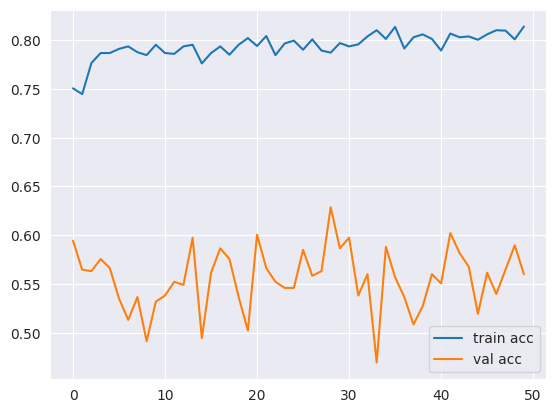

In [32]:
import matplotlib.pyplot as plt

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('/content/dense_net-acc-rps-1.png')

plt.show()

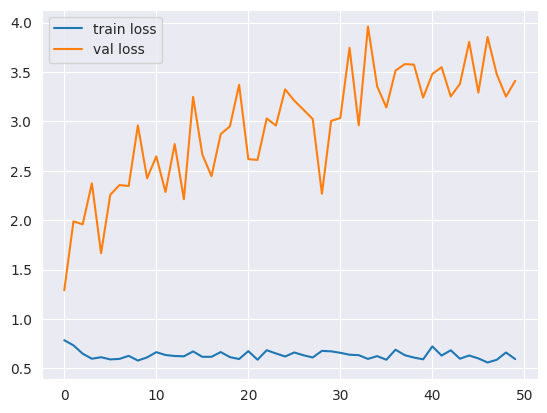

In [33]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('/content/dense_net-acc-rps-1.png')


plt.show()

In [34]:
print("[Loss, Accuracy] = ", model.evaluate(test_x,test_y,batch_size=16))

53/53 [==============================] - 3s 64ms/step - loss: 2.5549 - accuracy: 0.6994
[Loss, Accuracy] =  [2.5549395084381104, 0.6994082927703857]


In [38]:
import os
import cv2
import numpy as np

image_test_path = "/content/drive/My Drive/Osteoarthritis_Assignment_dataset/test"
image_test_lst = []
for img in os.listdir(image_test_path):
    image_path = os.path.join(image_test_path, img)
    img_arr = cv2.imread(image_path)

    # Check if the image is valid (not None and has non-zero dimensions)
    if img_arr is not None and img_arr.shape[0] > 0 and img_arr.shape[1] > 0:
        img_arr = cv2.resize(img_arr, (80, 80))
        image_test_lst.append(np.array(img_arr))

x = np.asarray(image_test_lst)
x = x / 255.0

# Now, you can use the x array for prediction with your model


In [40]:
model.save('/content/dense_net_model.h5')


In [41]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [42]:
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

27/27 [==============================] - 8s 32ms/step


In [43]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       533
           1       0.61      0.54      0.57       312

    accuracy                           0.70       845
   macro avg       0.68      0.67      0.67       845
weighted avg       0.69      0.70      0.70       845



In [44]:
#get confusion matrix
print(confusion_matrix(y_pred,test_y))

[[424 109]
 [145 167]]
